# Multi-device Processing

Particular setup allows you to have multiple processing devices, it is possible to take advantage of this in pyclesperanto to distribute your processing.
Although, for now, each device must work on separated data, one can distribute the workload in order to speed up the full computation

In [1]:
import numpy as np
import time

import pyclesperanto as cle
from skimage.io import imread

cle.list_available_devices()

['NVIDIA GeForce RTX 2080 SUPER',
 'pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz']

In [2]:
d1 = cle.select_device("TX")
d2 = cle.select_device("Intel")
print('first device:',d1)
print('second device:',d2)

first device: (OpenCL) NVIDIA GeForce RTX 2080 SUPER
second device: (OpenCL) pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz


## Associate operation to device

Let's first load some data to process

In [3]:
image = imread("https://samples.fiji.sc/blobs.png").squeeze()
image

array([[ 40,  32,  24, ..., 216, 200, 200],
       [ 56,  40,  24, ..., 232, 216, 216],
       [ 64,  48,  24, ..., 240, 232, 232],
       ...,
       [ 72,  80,  80, ...,  48,  48,  48],
       [ 80,  80,  80, ...,  48,  48,  48],
       [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)

We can now `push` the data on both device by using the `device` argument, and run different operations on both.

In [4]:
image1 = cle.push(image, device=d1)
image2 = cle.push(image, device=d2)

In [5]:
blurred1 = cle.gaussian_blur(image1, sigma_x=10)
blurred2 = cle.gaussian_blur(image2, sigma_y=5)

Here, blurred1 and blurred2 were processed simultanously on both device. We can observe the different output.

array([[ 40.09867 ,  41.156883,  42.50785 , ..., 189.27463 , 192.13885 ,
        194.54205 ],
       [ 50.640034,  51.278248,  52.21751 , ..., 202.75035 , 205.77882 ,
        208.34549 ],
       [ 56.174618,  56.58758 ,  57.299023, ..., 214.51335 , 217.79279 ,
        220.61713 ],
       ...,
       [ 69.127556,  68.62755 ,  68.08486 , ...,  63.774857,  61.41017 ,
         59.30248 ],
       [ 73.34248 ,  72.481384,  71.57082 , ...,  68.13706 ,  65.15866 ,
         62.496014],
       [ 82.46705 ,  81.12341 ,  79.76445 , ...,  72.53829 ,  69.04784 ,
         65.90595 ]], dtype=float32, mtype=buffer)
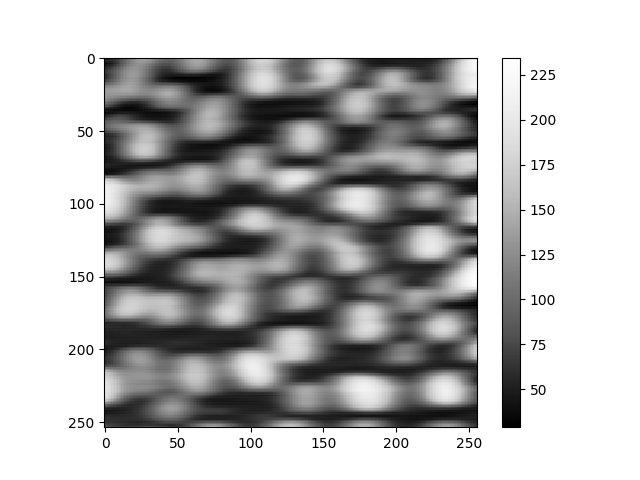
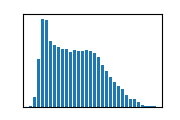

In [6]:
blurred1

array([[ 40.902157,  35.52846 ,  28.57356 , ..., 225.07469 , 212.74393 ,
        212.74393 ],
       [ 40.747154,  36.183662,  29.756958, ..., 226.44623 , 214.88696 ,
        214.88696 ],
       [ 40.56795 ,  36.867207,  31.014427, ..., 227.67151 , 216.88551 ,
        216.88551 ],
       ...,
       [ 76.24275 ,  76.0747  ,  72.87161 , ...,  47.891773,  49.0616  ,
         49.0616  ],
       [ 79.0909  ,  77.96501 ,  74.195816, ...,  47.92384 ,  48.865387,
         48.865387],
       [ 81.93995 ,  79.80999 ,  75.43991 , ...,  47.94881 ,  48.678448,
         48.678448]], dtype=float32, mtype=buffer)
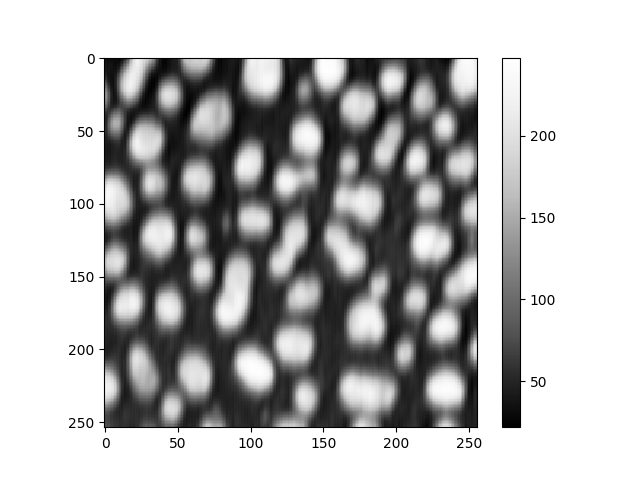
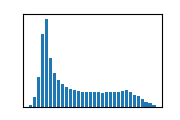

In [7]:
blurred2

Be aware however that both are into different device, it is then not possible to apply operation between them.

## Sequential vs Parallel processing

Let's use a bigger data to be able to see the time difference

In [8]:
# create a 100 MB test image
test_image = np.random.random((10, 1000, 1000)).astype(np.float32)

# push the image to memory of both GPUs.
image1 = cle.push(test_image, device=d1)
image2 = cle.push(test_image, device=d2)

We now execute the Gaussian blur on both devices sequentially a couple of times and measure the time it takes.

In [9]:
total_time = time.time()

print("processing on:", d1.name)
print("-------------")
for i in range(0, 5):
    start_time = time.time()
    
    # process image on first device
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from first GPU
    result1 = cle.pull(blurred1)
    print("Processing and pulling on", d1.name, "took", time.time() - start_time)

print("processing on:", d2.name)
print("-------------")
for i in range(0, 5):    
    start_time = time.time()
    # process image on second device
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from second GPU
    result2 = cle.pull(blurred2)
    print("Processing and pulling on", d2.name, "took", time.time() - start_time)
    
print("-------------")
print("Total time processing and pulling on both devices (sequential) took", time.time() - total_time)

processing on: NVIDIA GeForce RTX 2080 SUPER
-------------
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.03361010551452637
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.03200483322143555
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.030867338180541992
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.03219866752624512
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER took 0.03149890899658203
processing on: pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz
-------------
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 4.32673192024231
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 4.528825759887695
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 4.748322010040283
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz took 4.953486204147339
Processing and pulling on pthread-Intel(R) Core(TM) i7-7820X CPU @

You can clearly see that the one device is a bit slower than the other.  
We now repeat that experiment with a different call-order. If processing is done in parallel in the background, we will see that the processing time of each for-loop iteration is less than in the example above.   .
The time limiting factor is set by the slowest device

In [10]:
total_time = time.time()

print("processing on both:", d1.name, 'and', d2.name)
for i in range(0, 5):
    start_time = time.time()
    
    # process image on both GPUs
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)

    # retrieve result from both GPUs
    result1 = cle.pull(blurred1)
    result2 = cle.pull(blurred2)
    print("Processing and pulling on", d1.name, "and", d2.name, "in parallel took", time.time() - start_time)

print("-------------")
print("Total time processing and pulling on both devices (parallel) took", time.time() - total_time)

processing on both: NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 4.348502159118652
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 4.541377305984497
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 4.745493173599243
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 5.054869174957275
Processing and pulling on NVIDIA GeForce RTX 2080 SUPER and pthread-Intel(R) Core(TM) i7-7820X CPU @ 3.60GHz in parallel took 5.200477600097656
-------------
Total time processing and pulling on both devices (parallel) took 23.891294956207275
